# Baseline

In [1]:
import numpy as np

import seaborn as sns
sns.set()

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [4]:
from mdp import TimeSeries
from mdp import MarketData
from mdp import MovingWindowFeatures
from mdp import ClassificationGenerator, RegressionGenerator, MultitaskGenerator
from mdp import invert_log_ret

import mdp.utils as utils
import mdp.plotHelpers as plotHelpers

In [5]:
import importlib

import mdp

importlib.reload(mdp)
importlib.reload(mdp.datasetGenerator)
importlib.reload(mdp.marketData)
importlib.reload(mdp.movingWindowFeatures)
importlib.reload(mdp.timeSeries)
importlib.reload(mdp.plotHelpers)
importlib.reload(mdp.utils);

# *Параметры*

In [6]:
INSTRUMENT = 'CVX' # Chevron corp
START_FROM = '2008-11-14'
WINDOW_SIZE = 30
FORECAST_OFFSET=1

VAL_SPLIT = '2019-01-01'
TEST_SPLIT = '2019-06-01'
FORCE_TRAIN = True

# *Исходные данные*

Загрузка данных и вычисление индикаторов.

In [7]:
instr = MarketData.create_from_tiingo(INSTRUMENT, start=START_FROM)

## Целевая переменная

Цена закрытия.

In [8]:
orig_target = instr.c

Переходим к логарифмической доходности.

In [9]:
transformed_target = instr.c.transform(transforms={'ratios' : {}, 'ln' : {}})

In [10]:
def make_feature_selector():
    price_transformer = lambda: {'ratios': {}, 'ln': {}}
    diff_transformer = lambda o: {'diffs': {'order': o}}
    identity_transformer = lambda: {}
    feature_transformations = {
        'c': price_transformer(),
    }
    return feature_transformations

In [11]:
instr_transformed = instr.select_transform(make_feature_selector())

In [12]:
transformed_target = instr_transformed.c

## Обучающая, валидационная и тестовая выборки

In [13]:
instr_train, instr_val_test = instr_transformed.train_test_split(VAL_SPLIT, window_size=WINDOW_SIZE,
                                                                 scaler=None)
#                                                                  scaler=MinMaxScaler,
#                                                                  scaler_kwargs={'feature_range': (-1, 1)})

instr_val, instr_test = instr_val_test.train_test_split(TEST_SPLIT, window_size=WINDOW_SIZE, scaler=None)

len(instr_train), len(instr_val), len(instr_test)

(2514, 134, 172)

# *Модели*

## Регрессия: случайное блуждание

Прогноз - следующее значение равно предыдущему, то есть прогнозируемая доходность - постоянная и равная 0.

In [14]:
pred_log_ret_test = np.zeros(len(instr_test))

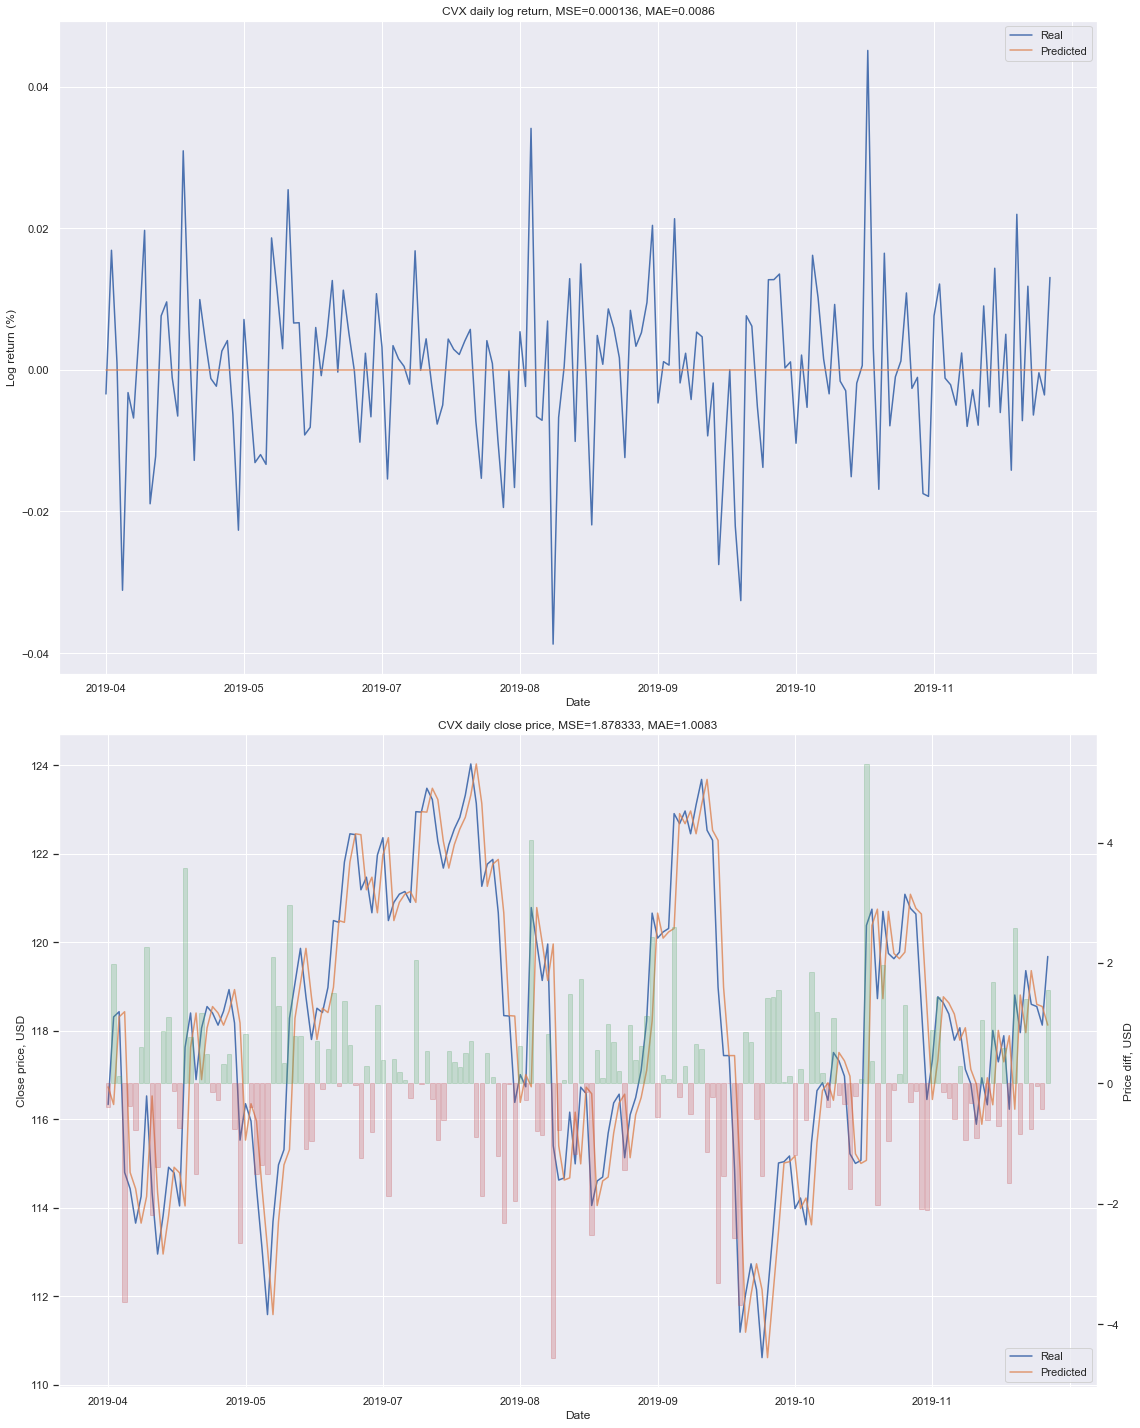

In [15]:
plotHelpers.plot_regr_predictions(orig_target, instr_test, pred_log_ret_test, figsize=(16, 20))

## Классификация: подбрасывание монеты

Метрики классификации в данном случае, очевидно, практического смысла не имеют: хотя в среднем ROC AUC будет равен 0.5, но в какой-то отдельной реализации он может случайно получиться относительно большой. Тем не менее для примера посчитаем метрики и здесь.

In [16]:
pred_direction_proba = np.random.uniform(size=len(instr_test))
predicted_direction = (0.5 < pred_direction_proba).astype(np.int)

true_direction = ClassificationGenerator.get_target_direction(instr_test.c[-len(pred_direction_proba):].data)

In [17]:
print(classification_report(true_direction, predicted_direction))

              precision    recall  f1-score   support

           0       0.49      0.50      0.50        84
           1       0.52      0.51      0.51        88

    accuracy                           0.51       172
   macro avg       0.51      0.51      0.51       172
weighted avg       0.51      0.51      0.51       172



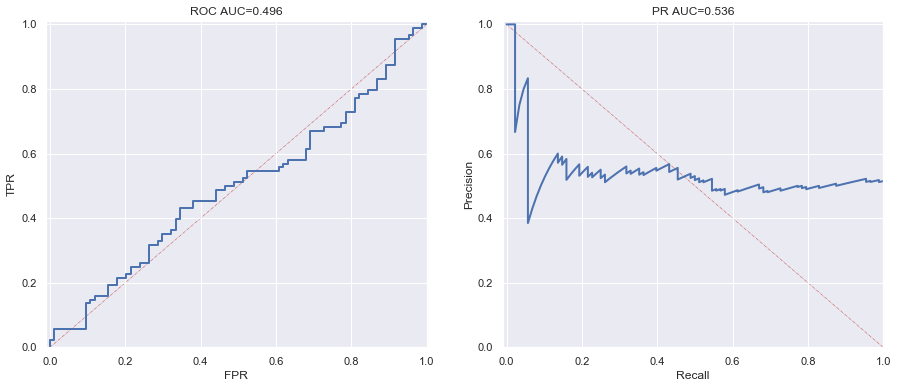

In [18]:
plotHelpers.plot_roc_pr_curves(true_direction, pred_direction_proba)